# Introduction

<img src="https://miro.medium.com/max/2800/1*TUF_YfybJPQ8WA0siWeJTg@2x.jpeg" alt="Brain" style="width: 800px;">

### Note

---

# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"Files in {dirname}:")
    for filename in filenames:
        print(filename)
    for filename in filenames:
        print(os.path.join(dirname, filename))

Files in /kaggle/input:
Files in /kaggle/input/brain-tumor-classification-mri:
Files in /kaggle/input/brain-tumor-classification-mri/Training:
Files in /kaggle/input/brain-tumor-classification-mri/Training/no_tumor:
image(84).jpg
image(44).jpg
image(245).jpg
6.jpg
image(238).jpg
image(196).jpg
image(108).jpg
image(310).jpg
image (5).jpg
image(186).jpg
image(29).jpg
image(140).jpg
image(224).jpg
image (61).jpg
image(173).jpg
image(52).jpg
image (52).jpg
image(174).jpg
image(203).jpg
image(33).jpg
image(283).jpg
image(291).jpg
image(243).jpg
image(284).jpg
image(106).jpg
5.jpg
image(69).jpg
image(302).jpg
8.jpg
image(21).jpg
image(258).jpg
image(103).jpg
image(265).jpg
image(289).jpg
image(278).jpg
image(215).jpg
image(155).jpg
image(184).jpg
image (40).jpg
image (26).jpg
image(193).jpg
image(74).jpg
image(35).jpg
image(6).jpg
image(15).jpg
image(132).jpg
image(135).jpg
image (23).jpg
image(168).jpg
image(81).jpg
image(204).jpg
image(207).jpg
image(13).jpg
image(293).jpg
image(226).jpg
i

---

# Color

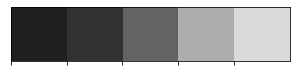

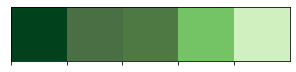

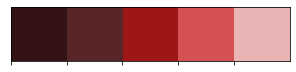

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [4]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 75.30it/s]


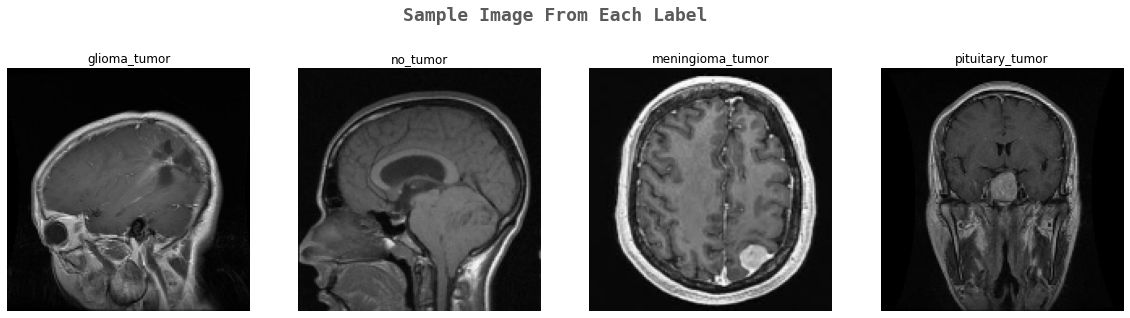

In [5]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [7]:
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri', 'Training', i)
    print("Folder:", folderPath)
    print("Label:", i)

Folder: ../input/brain-tumor-classification-mri/Training/glioma_tumor
Label: glioma_tumor
Folder: ../input/brain-tumor-classification-mri/Training/no_tumor
Label: no_tumor
Folder: ../input/brain-tumor-classification-mri/Training/meningioma_tumor
Label: meningioma_tumor
Folder: ../input/brain-tumor-classification-mri/Training/pituitary_tumor
Label: pituitary_tumor


In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [7]:
X_train.shape

(3264, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.

The include_top parameter is set to *False* so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [10]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16711680/16705208 [==============================] - 1s 0us/step


**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while *pooling*. This really helps in decreasing the computational load on the machine while training.
<br><br>
**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The **rate** parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the **softmax** function which is a generalization of the sigmoid function.

In [11]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

We finally compile our model.

In [13]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

NameError: name 'test_set' is not defined

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.<br><br>
By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

In [14]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

**Note**: The training takes alot of time! ~ 2 hours for me (Using CPU)<br>
Barely took 5 minutes with the GPU.

In [15]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - 26s 154ms/step - loss: 0.6729 - accuracy: 0.7434 - val_loss: 0.6543 - val_accuracy: 0.8231

Epoch 00001: val_accuracy improved from -inf to 0.82313, saving model to effnet.h5
Epoch 2/12
83/83 [==============================] - 9s 112ms/step - loss: 0.1754 - accuracy: 0.9416 - val_loss: 0.5117 - val_accuracy: 0.8707

Epoch 00002: val_accuracy improved from 0.82313 to 0.87075, saving model to effnet.h5
Epoch 3/12
83/83 [==============================] - 9s 112ms/step - loss: 0.1366 - accuracy: 0.9587 - val_loss: 0.8563 - val_accuracy: 0.7823

Epoch 00003: val_accuracy did not improve from 0.87075
Epoch 4/12
83/83 [==============================] - 9s 112ms/step - loss: 0.1120 - accuracy: 0.9644 - val_loss: 0.4200 - val_accuracy: 0.8741

Epoch 00004: val_accuracy improved from 0.87075 to 0.87415, saving model to effnet.h5
Epoch 5/12
83/83 [==============================] - 9s 112ms/step - loss: 0.0617 - accuracy: 0.9792 - val_loss: 0.676

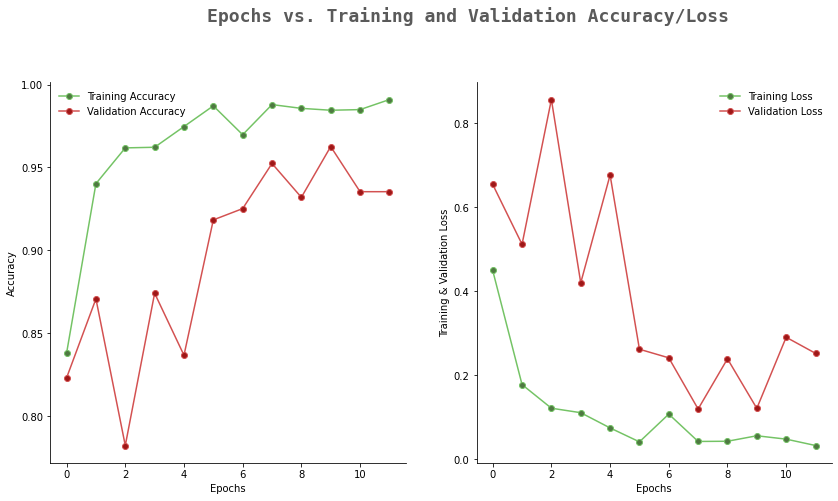

In [16]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

# Prediction

In [17]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

---

# Evaluation

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [18]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93        93
           1       0.98      1.00      0.99        51
           2       0.87      0.97      0.92        96
           3       0.98      0.95      0.97        87

    accuracy                           0.94       327
   macro avg       0.95      0.95      0.95       327
weighted avg       0.95      0.94      0.95       327



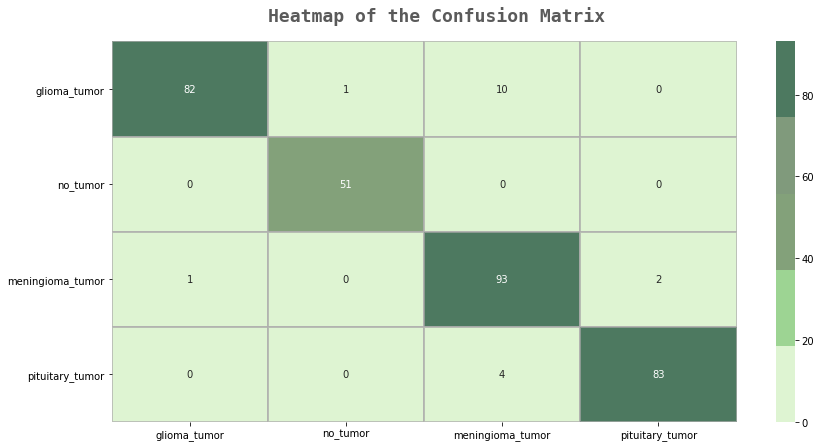

In [19]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

---

In [31]:
# Print Folder Names and Corresponding Labels
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri', 'Training', i)
    print("Folder:", folderPath)
    print("Label:", i)


Folder: ../input/brain-tumor-classification-mri/Training/glioma_tumor
Label: glioma_tumor
Folder: ../input/brain-tumor-classification-mri/Training/no_tumor
Label: no_tumor
Folder: ../input/brain-tumor-classification-mri/Training/meningioma_tumor
Label: meningioma_tumor
Folder: ../input/brain-tumor-classification-mri/Training/pituitary_tumor
Label: pituitary_tumor


In [20]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')



This is where you can upload the image by clicking on the **Upload** button:

In [21]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

After uploading the image, you can click on the **Predict** button below to make predictions:

In [22]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def img_pred(file_path):
    img = Image.open(file_path)
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage, (150, 150))
    img = img.reshape(1, 150, 150, 3)
    p = model.predict(img)
    p = np.argmax(p, axis=1)[0]

    if p == 0:
        prediction = 'Glioma Tumor'
    elif p == 1:
        prediction = 'The model predicts that there is no tumor'
    elif p == 2:
        prediction = 'Meningioma Tumor'
    else:
        prediction = 'Pituitary Tumor'

    plt.imshow(opencvImage)
    plt.title(f'Prediction: {prediction}')
    plt.axis('off')
    plt.show()

    return prediction




In [ ]:
result = img_pred('/kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(10).jpg')
print(result)


---

# <center>Thank You!